# Importing Libraries


In [ ]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 400.0 kB/s eta 0:00:00


In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch.optim as optim
from torchvision import models
from math import sqrt
import torch
import torch.nn.functional as F
from torch import nn
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Classification

create dataloaders

In [ ]:
train_transformation = transforms.Compose([
    transforms.RandomResizedCrop(size=(32, 32), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

#create training and test dataset
training = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transformation)
test = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transformation)

size_batch = 32
#create training and test loaders
train_loader = torch.utils.data.DataLoader(training, batch_size=size_batch,shuffle=True, num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=size_batch,shuffle=False, num_workers=2,drop_last=True)

#classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 97367762.01it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


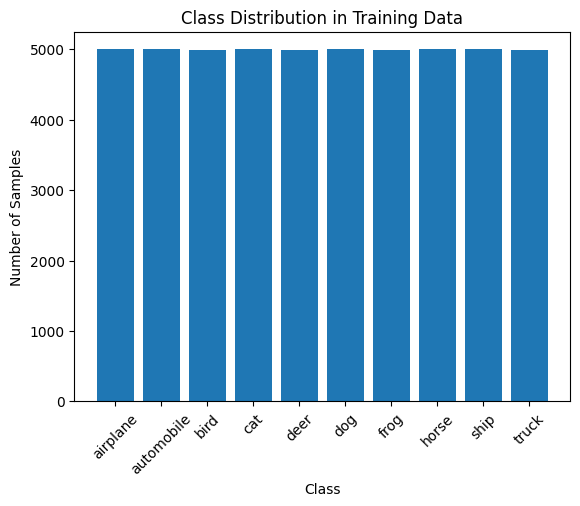

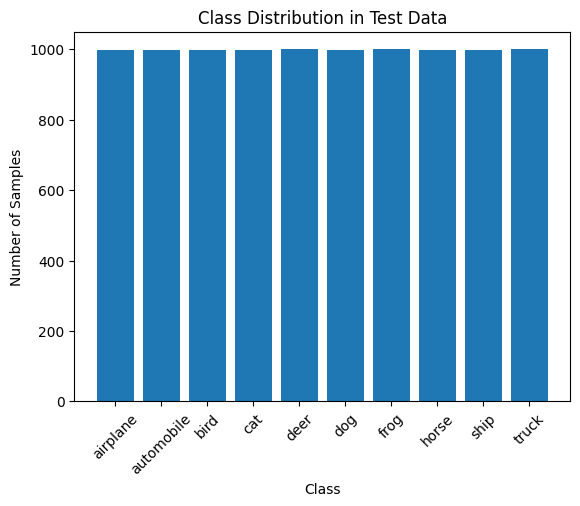

In [ ]:
def check_class_distribution(dataset, loader, name):
    classes = dataset.classes
    num_classes = len(classes)
    class_count = np.zeros(10)  #count occurrences of each class
    shape_image = None
    for images, labels in loader:
        if shape_image is None:
            shape_image = images[0].shape
        for label in labels:
            class_count[label] += 1
    plt.bar(classes, class_count)
    plt.title(f"Class Distribution in {name}")
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=45)  #better readability
    plt.show()
    return shape_image, num_classes


#distribution for training data
shape_image_train, num_classes_train = check_class_distribution(training,train_loader, "Training Data")
#distribution for test data
shape_image_test, num_classes_test = check_class_distribution(test, test_loader, "Test Data")

In [ ]:
#sanity check
if shape_image_train == shape_image_test:
  #input_size = torch.prod(torch.tensor(shape_image_train)).item()
  input_size = torch.tensor(shape_image_train)
if num_classes_train == num_classes_test:
  output_size = num_classes_train
print(input_size, output_size)
'''
print(int(input_size[0]))
print(int(input_size[1]))
print(int(input_size[2]))
'''

tensor([ 3, 32, 32]) 10


'\nprint(int(input_size[0]))\nprint(int(input_size[1]))\nprint(int(input_size[2]))\n'

In [ ]:
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_device()
print(device)

cpu


In [ ]:
# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class LSA(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.temperature = nn.Parameter(torch.log(torch.tensor(dim_head ** -0.5)))

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.temperature.exp()

        mask = torch.eye(dots.shape[-1], device = dots.device, dtype = torch.bool)
        mask_value = -torch.finfo(dots.dtype).max
        dots = dots.masked_fill(mask, mask_value)

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, LSA(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class SPT(nn.Module):
    def __init__(self, *, dim, patch_size, channels = 3):
        super().__init__()
        patch_dim = patch_size * patch_size * 5 * channels

        self.to_patch_tokens = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim)
        )

    def forward(self, x):
        shifts = ((1, -1, 0, 0), (-1, 1, 0, 0), (0, 0, 1, -1), (0, 0, -1, 1))
        shifted_x = list(map(lambda shift: F.pad(x, shift), shifts))
        x_with_shifts = torch.cat((x, *shifted_x), dim = 1)
        return self.to_patch_tokens(x_with_shifts)

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = SPT(dim = dim, patch_size = patch_size, channels = channels)

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [ ]:
model = ViT(image_size=32,patch_size=4,num_classes=10,dim=512,depth=12,heads=8,mlp_dim=512,channels=3)
file_path = '/content/drive/My Drive/Machine Intelligence Project/Project 2/vit_small_original200-4-ckpt.pth'

checkpoint = torch.load(file_path, map_location=torch.device('cpu'))

model_weights = checkpoint['model'] if 'model' in checkpoint else checkpoint

model.load_state_dict(model_weights, strict=False)

model.eval()

ViT(
  (to_patch_embedding): SPT(
    (to_patch_tokens): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
      (1): LayerNorm((240,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=240, out_features=512, bias=True)
    )
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-11): 12 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (fn): LSA(
            (attend): Softmax(dim=-1)
            (to_qkv): Linear(in_features=512, out_features=1536, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=512, out_features=512, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
            

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10) #number of epochs

In [ ]:
"""Testing the model and print values."""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    # original and attacked output label
    outputs_orig = model(images)
    _, predicted_orig = torch.max(outputs_orig.data, 1)
    correct_predictions_orig = torch.eq(predicted_orig, labels).sum().item()
    # loss
    loss_orig = F.cross_entropy(outputs_orig, labels)

    # labels and loss values
    print("Original labels: ", labels.cpu().numpy())
    print("Loss on original images: ", loss_orig.item())

accuracy_orig = correct_predictions_orig / len(labels)
print(f"Accuracy: {accuracy_orig}")


Original labels:  [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5 2 4 0 9 6 6 5]
Loss on original images:  0.350315123796463
Original labels:  [4 5 9 2 4 1 9 5 4 6 5 6 0 9 3 9 7 6 9 8 0 3 8 8 7 7 4 6 7 3 6 3]
Loss on original images:  0.6275948882102966
Original labels:  [6 2 1 2 3 7 2 6 8 8 0 2 9 3 3 8 8 1 1 7 2 5 2 7 8 9 0 3 8 6 4 6]
Loss on original images:  0.42797568440437317
Original labels:  [6 0 0 7 4 5 6 3 1 1 3 6 8 7 4 0 6 2 1 3 0 4 2 7 8 3 1 2 8 0 8 3]
Loss on original images:  0.6021463871002197
Original labels:  [5 2 4 1 8 9 1 2 9 7 2 9 6 5 6 3 8 7 6 2 5 2 8 9 6 0 0 5 2 9 5 4]
Loss on original images:  0.6643080115318298
Original labels:  [2 1 6 6 8 4 8 4 5 0 9 9 9 8 9 9 3 7 5 0 0 5 2 2 3 8 6 3 4 0 5 8]
Loss on original images:  0.7937750816345215
Original labels:  [0 1 7 2 8 8 7 8 5 1 8 7 1 3 0 5 7 9 7 4 5 9 8 0 7 9 8 2 7 6 9 4]
Loss on original images:  0.3874407410621643
Original labels:  [3 9 6 4 7 6 5 1 5 8 8 0 4 0 5 5 1 1 8 9 0 3 1 9 2 2 5 3 9 9 4 0]
Loss on origi

In [ ]:
# Noise
def adversarial_noise(images, epsilon=1):
    """Add random adversarial noise to the images."""
    noise = epsilon * torch.randn_like(images) #random noise
    noised_images = images + noise # adding noise
    return torch.clamp(noised_images, 0, 255) # making sure pixel values are valid

In [ ]:
# FGSM
def FGSM(model, image,labels, epsilon=1):
    """
      The FGSM is an attack method designed to fool models by perturbing the input data slightly in a way that maximizes the loss.
      This function implements FGSM by taking a single image and its label, applying a gradient-based perturbation, and returning the modified image.
      The perturbation magnitude is controlled by `epsilon`, which determines how much to move along the gradient's sign direction.

    Parameters:
    - model : The neural network model which is being attacked.
    - image : A single image tensor for which the adversarial example is to be generated.
    - labels : The true labels associated with the image tensor.
    - epsilon : The perturbation magnitude used to create the adversarial image.

    Output:
    - perturbed_image : The image tensor after the FGSM attack, perturbed such that it aims to maximize the classification loss.
"""
    image.requires_grad = True
    outputs = model(image)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()
    image_grad = image.grad.data
    sign_image_grad = image_grad.sign()
    perturbed_image = image + epsilon * sign_image_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 255)

    return perturbed_image

In [ ]:
# PGD
def PGD(model, image,labels, epsilon=1,alpha = 1, num_iter = 10):
    """
    The Projected Gradient Descent is an iterative method used to create adversarial examples by subtly and incrementally changing an image to maximize model error.
    This function handles the attack by taking a single image and its label, applying small, controlled changes, and ensuring these changes stay within a defined limit, epsilon.
    The amount adjusted per step is set by alpha, and the process repeats for a specified number of iterations to refine the adversarial effect.

    Parameters:
    - model : The neural network model which is being attacked.
    - image : A single image tensor for which the adversarial example is to be generated.
    - labels : The true labels associated with the image tensor.
    - epsilon : The perturbation magnitude used to create the adversarial image.
    - alpha : The step size for each iteration determining how much the image is modified at each step.
    - num-iter : The number of iterations to perform.

    Output:
    - perturbed_image : The image tensor after the PGD attack.
"""
    image.requires_grad = True
    criterion = nn.CrossEntropyLoss()
    for i in range(num_iter):
      outputs = model(image)
      loss = criterion(outputs, labels)
      model.zero_grad()
      loss.backward()
      image_grad = image.grad.data
      sign_image_grad = image_grad.sign()
      attacked_image = image + alpha * sign_image_grad
      dist = torch.clamp(attacked_image - image, -epsilon, epsilon)
      perturbed_image = torch.clamp(attacked_image - image, -epsilon, epsilon)
      perturbed_image = torch.clamp(perturbed_image, 0, 255)
    return perturbed_image

In [ ]:
def adversarial_examples(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    total_correct_orig = 0
    total_correct1 = 0
    total_correct2 = 0
    total_correct3 = 0
    total_samples = 0
    total_loss_orig = 0
    total_loss_adv = 0
    total_loss_adv2 = 0
    total_loss_adv3 = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        batch_size = labels.size(0)

        # Generate adversarial examples
        adv_images = adversarial_noise(images)
        adv_images2 = FGSM(model, images)
        adv_images3 = PGD(model, images)

        # Evaluate the model on both original and adversarial images
        outputs_orig = model(images)
        outputs_adv = model(adv_images)
        outputs_adv2 = model(adv_images2)
        outputs_adv3 = model(adv_images3)

        # Calculate loss
        loss_orig = F.cross_entropy(outputs_orig, labels)
        loss_adv = F.cross_entropy(outputs_adv, labels)
        loss_adv2 = F.cross_entropy(outputs_adv2, labels)
        loss_adv3 = F.cross_entropy(outputs_adv3, labels)

        total_loss_orig += loss_orig.item() * batch_size
        total_loss_adv += loss_adv.item() * batch_size
        total_loss_adv2 += loss_adv2.item() * batch_size
        total_loss_adv3 += loss_adv3.item() * batch_size

        # Calculate accuracy
        _, predicted_orig = torch.max(outputs_orig.data, 1)
        _, predicted1 = torch.max(outputs_adv.data, 1)
        _, predicted2 = torch.max(outputs_adv2.data, 1)
        _, predicted3 = torch.max(outputs_adv3.data, 1)

        total_correct_orig += torch.eq(predicted_orig, labels).sum().item()
        total_correct1 += torch.eq(predicted1, labels).sum().item()
        total_correct2 += torch.eq(predicted2, labels).sum().item()
        total_correct3 += torch.eq(predicted3, labels).sum().item()
        total_samples += batch_size

    # Print aggregated results
    print("Overall Original Accuracy:", total_correct_orig / total_samples)
    print("Overall Accuracy on Noisy Images:", total_correct1 / total_samples)
    print("Overall Accuracy on FGSM Images:", total_correct2 / total_samples)
    print("Overall Accuracy on PGD Images:", total_correct3 / total_samples)
    print("Average Loss on Original Images:", total_loss_orig / total_samples)
    print("Average Loss on Noisy Adversarial Images:", total_loss_adv / total_samples)
    print("Average Loss on FGSM Images:", total_loss_adv2 / total_samples)
    print("Average Loss on PGD Images:", total_loss_adv3 / total_samples)

In [ ]:
adversarial_examples(model, test_loader)

Overall Original Accuracy: 0.7860576923076923
Overall Accuracy on Noisy Images: 0.12580128205128205
Overall Accuracy on FGSM Images: 0.1775841346153846
Overall Accuracy on PGD Images: 0.12419871794871795
Average Loss on Original Images: 0.6210591080956734
Average Loss on Noisy Adversarial Images: 5.001135418048272
Average Loss on FGSM Images: 3.9555944364804487
Average Loss on PGD Images: 4.683267840972314


# Defense

In [ ]:
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = 10 #change it to whatever number you want
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        #print(inputs.shape)
        #print(labels.shape)
        #sys.exit()
        # zero the parameter gradients
        optimizer.zero_grad()
        if i%2 == 0:
          adv_images = adversarial_noise(inputs)
          # forward + backward + optimize
          outputs = model(0.2 * adv_images.to(device))
        else:
          outputs = model(inputs)
        loss = criterion(outputs, labels)
        #normalized_loss = loss.mean() / len(inputs)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        # Print statistics
        running_loss += loss.item()
        #print(f'Epoch [{epoch + 1}/{5}], Batch [{i + 1}/{len(train_loader)}], Loss: {loss.item():.3f}')
        if i == len(train_loader) - 1:  # If it's the last mini-batch
            # Print the average loss over the epoch
            print(f'Epoch [{epoch + 1}/{epochs}], Average Loss: {running_loss / (i + 1):.3f}')
            running_loss = 0.0
    scheduler.step(epoch-1)
print('Finished Training')


Epoch [1/10], Average Loss: 2.127


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [2/10], Average Loss: 2.136
Epoch [3/10], Average Loss: 2.152
Epoch [4/10], Average Loss: 2.136
Epoch [5/10], Average Loss: 2.149
Epoch [6/10], Average Loss: 2.150
Epoch [7/10], Average Loss: 2.140
Epoch [8/10], Average Loss: 2.136
Epoch [9/10], Average Loss: 2.147
Epoch [10/10], Average Loss: 2.132
Finished Training


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class DnCNN(nn.Module):
    def __init__(self, channels=3, num_of_layers=17):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        features = 64
        layers = [nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False),
                  nn.ReLU(inplace=True)]
        for _ in range(num_of_layers-2):
            layers.append(nn.Conv2d(features, features, kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(features, channels, kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        out = self.dncnn(x)
        return x - out


In [ ]:
dncnn = DnCNN(channels=3)  # Assuming the model expects 3-channel inputs
dncnn.to(device)
if next(dncnn.parameters()).is_cuda:
    print("model moved to cuda")

dncnn.load_state_dict(torch.load('/content/drive/MyDrive/Machine Intelligence Project/Project 2/dncnn_model.pth', map_location=torch.device('cpu')))
dncnn.eval()  # Set the model to evaluation mode

def adversarial_examples(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    total_correct_orig = 0
    total_correct_noisy = 0
    total_correct_fgsm = 0
    total_correct_pgd = 0
    total_correct_Fia = 0
    total_correct_deepfool = 0
    total_correct_JSM = 0
    total_correct_cw = 0
    total_samples = 0  # Track the total number of samples processed

    for images, labels in dataloader:
        batch_size = images.size(0)  # Get the actual size of the batch
        images, labels = images.to(device), labels.to(device)

        target_label = (labels + 1) % output_size
        target_label = target_label.to(device)

        # Generate adversarial examples (placeholder functions)
        adv_images = adversarial_noise(images)
        #print(labels.shape)
        #print(images.shape)
        adv_images2 = FGSM(model, images, labels)
        adv_images3 = PGD(model, images,labels)
        #adv_images4 = FIA(model, images,target_label)
        #adv_images5 = cw_attack(model, images,target_label)
        #adv_images6 = deepfool(model, images,labels,target_label)
        #adv_images7 = JSM(model, images,labels)

        # Denoising using DnCNN (assuming dncnn is defined and loaded)
        denoised_images = dncnn(adv_images)
        denoised_images2 = dncnn(adv_images2)
        denoised_images3 = dncnn(adv_images3)
        #denoised_images4 = dncnn(adv_images4)
        #denoised_images5 = dncnn(adv_images5)
        #denoised_images6 = dncnn(adv_images6)
        #denoised_images7 = dncnn(adv_images7)


        # Evaluate the model on both original and denoised images
        outputs_orig = model(images)
        outputs_adv = model(denoised_images)
        outputs_adv2 = model(denoised_images2)
        outputs_adv3 = model(denoised_images3)
        #outputs_adv4 = model(denoised_images4)
        #outputs_adv5 = model(denoised_images5)
        #outputs_adv6 = model(denoised_images6)
        #outputs_adv7 = model(denoised_images7)


        # Compute accuracy
        _, predicted_orig = torch.max(outputs_orig.data, 1)
        _, predicted1 = torch.max(outputs_adv.data, 1)
        _, predicted2 = torch.max(outputs_adv2.data, 1)
        _, predicted3 = torch.max(outputs_adv3.data, 1)
        #_, predicted4 = torch.max(outputs_adv4.data, 1)
        #_, predicted5 = torch.max(outputs_adv5.data, 1)
        #_, predicted6 = torch.max(outputs_adv6.data, 1)
        #_, predicted7 = torch.max(outputs_adv7.data, 1)


        total_correct_orig += torch.eq(predicted_orig, labels).sum().item()
        total_correct_noisy += torch.eq(predicted1, labels).sum().item()
        total_correct_fgsm += torch.eq(predicted2, labels).sum().item()
        total_correct_pgd += torch.eq(predicted3, labels).sum().item()
        #total_correct_FIA += torch.eq(predicted4, labels).sum().item()
        #total_correct_cw += torch.eq(predicted5, labels).sum().item()
        #total_correct_deepfool += torch.eq(predicted6, labels).sum().item()
        #total_correct_JSM += torch.eq(predicted7, labels).sum().item()
        total_samples += batch_size  # Update total samples processed

    # Print overall accuracy
    print("Overall Original Accuracy:", total_correct_orig / total_samples)
    print("Overall Accuracy on Noisy Images:", total_correct_noisy / total_samples)
    print("Overall Accuracy on FGSM Images:", total_correct_fgsm / total_samples)
    print("Overall Accuracy on PGD Images:", total_correct_pgd / total_samples)
    #print("Overall Accuracy on FIA Images:", total_correct_FIA / total_samples)
    #print("Overall Accuracy on CW Images:", total_correct_cw / total_samples)
    #print("Overall Accuracy on deepfool Images:", total_correct_deepfool / total_samples)
    #print("Overall Accuracy on JSM Images:", total_correct_JSM / total_samples)

adversarial_examples(model, test_loader)

In [ ]:
torch.save(model.state_dict(), 'VIT_adv_model.pth')


In [ ]:
adversarial_examples(model, test_loader)# previous adversarial training

Overall Original Accuracy: 0.21544471153846154
Overall Accuracy on Noisy Images: 0.1661658653846154
Overall Accuracy on FGSM Images: 0.13962339743589744
Overall Accuracy on PGD Images: 0.10236378205128205
Average Loss on Original Images: 2.0437920158490157
Average Loss on Noisy Adversarial Images: 2.1797405584500384
Average Loss on FGSM Images: 2.258101869852115
Average Loss on PGD Images: 2.402183533479006
